In [5]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, LeNet, AlexNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [7]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [8]:
batch_size = 64
epoch_num = 300

# initialise the image preprocessors
sp = SimplePreProcessor(width=28, height=28)
iap = ImageToArrayPreprocessor()

In [10]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/DataRepo"
dbTrainPath = f"{dbBase}//train_threshinv_10class_28px1px_255div.hdf5"
dbValidPath = f"{dbBase}//validate_threshinv_10class_28px1px_255div.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 10
Unique Labels: ['Bearings', 'Bolts', 'Brackets', 'Bushing', 'Collets', 'Pipes', 'PushRings', 'Springs', 'Sprockets', 'Washers']


In [11]:
# consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4 5 6 7 8 9]
ClassWeights: [1.0111234 1.0545243 1.0179172 1.002205  1.        1.6802218 1.9718004
 1.0925481 1.6378379 1.515    ]


In [12]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [13]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [14]:
#model = AlexNet.build(width=80, height=80, depth=3, classes=class_num)
model = LeNet.build(width=28,
                    height=28,
                    depth=1,
                    classes=10)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
__________

In [16]:
# compile and optimise model
opt = SGD(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [17]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=10,
    verbose=1,
    callbacks=callbacks,
    class_weight=classWeight
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
116/116 [==============================] - 3s 26ms/step - loss: 2.2132 - acc: 0.1817 - val_loss: 2.1081 - val_acc: 0.2337
Epoch 2/300
116/116 [==============================] - 2s 17ms/step - loss: 2.0526 - acc: 0.2975 - val_loss: 1.8143 - val_acc: 0.4199
Epoch 3/300
116/116 [==============================] - 2s 18ms/step - loss: 1.7881 - acc: 0.4062 - val_loss: 1.4187 - val_acc: 0.5048
Epoch 4/300
116/116 [==============================] - 2s 16ms/step - loss: 1.5983 - acc: 0.4480 - val_loss: 1.3607 - val_acc: 0.4537
Epoch 5/300
116/116 [==============================] - 2s 16ms/step - loss: 1.4924 - acc: 0.4878 - val_loss: 1.1214 - val_acc: 0.6158
Epoch 6/300
116/116 [==============================] - 2s 16ms/step - loss: 1.3778 - acc: 0.5175 - val_loss: 1.0707 - val_acc: 0.6398
Epoch 7/300
116/116 [==============================] - 2s 16ms/step - loss: 1.2891 - acc: 0.5520 - val_loss: 0.9340 - val_acc: 0.6972
Epoch 8/300
11

Epoch 38/300
116/116 [==============================] - 2s 16ms/step - loss: 0.6177 - acc: 0.8027 - val_loss: 0.4081 - val_acc: 0.8870
Epoch 39/300
116/116 [==============================] - 2s 16ms/step - loss: 0.6173 - acc: 0.7980 - val_loss: 0.4073 - val_acc: 0.8934
Epoch 40/300
116/116 [==============================] - 2s 16ms/step - loss: 0.5969 - acc: 0.8026 - val_loss: 0.4444 - val_acc: 0.8810
Epoch 41/300
116/116 [==============================] - 2s 17ms/step - loss: 0.5927 - acc: 0.8035 - val_loss: 0.4217 - val_acc: 0.8641
Epoch 42/300
116/116 [==============================] - 2s 16ms/step - loss: 0.5975 - acc: 0.8037 - val_loss: 0.3688 - val_acc: 0.8925
Epoch 43/300
116/116 [==============================] - 2s 17ms/step - loss: 0.5864 - acc: 0.8088 - val_loss: 0.3930 - val_acc: 0.8756
Epoch 44/300
116/116 [==============================] - 2s 17ms/step - loss: 0.5891 - acc: 0.8105 - val_loss: 0.4665 - val_acc: 0.8523
Epoch 45/300
116/116 [==============================] -

Epoch 76/300
116/116 [==============================] - 2s 16ms/step - loss: 0.4376 - acc: 0.8611 - val_loss: 0.3476 - val_acc: 0.9177
Epoch 77/300
116/116 [==============================] - 2s 17ms/step - loss: 0.4539 - acc: 0.8537 - val_loss: 0.3026 - val_acc: 0.9196
Epoch 78/300
116/116 [==============================] - 2s 16ms/step - loss: 0.4288 - acc: 0.8642 - val_loss: 0.2708 - val_acc: 0.9221
Epoch 79/300
116/116 [==============================] - 2s 16ms/step - loss: 0.4414 - acc: 0.8581 - val_loss: 0.3409 - val_acc: 0.9103
Epoch 80/300
116/116 [==============================] - 2s 17ms/step - loss: 0.4411 - acc: 0.8596 - val_loss: 0.2568 - val_acc: 0.9295
Epoch 81/300
116/116 [==============================] - 2s 21ms/step - loss: 0.4228 - acc: 0.8641 - val_loss: 0.2803 - val_acc: 0.9327
Epoch 82/300
116/116 [==============================] - 2s 17ms/step - loss: 0.4233 - acc: 0.8626 - val_loss: 0.2945 - val_acc: 0.9056
Epoch 83/300
116/116 [==============================] -

Epoch 114/300
116/116 [==============================] - 2s 18ms/step - loss: 0.3522 - acc: 0.8905 - val_loss: 0.2279 - val_acc: 0.9416
Epoch 115/300
116/116 [==============================] - 2s 17ms/step - loss: 0.3434 - acc: 0.8895 - val_loss: 0.2227 - val_acc: 0.9394
Epoch 116/300
116/116 [==============================] - 2s 16ms/step - loss: 0.3531 - acc: 0.8903 - val_loss: 0.2174 - val_acc: 0.9368
Epoch 117/300
116/116 [==============================] - 2s 17ms/step - loss: 0.3473 - acc: 0.8891 - val_loss: 0.2194 - val_acc: 0.9419
Epoch 118/300
116/116 [==============================] - 2s 17ms/step - loss: 0.3377 - acc: 0.8957 - val_loss: 0.2265 - val_acc: 0.9464
Epoch 119/300
116/116 [==============================] - 2s 18ms/step - loss: 0.3478 - acc: 0.8861 - val_loss: 0.2367 - val_acc: 0.9365
Epoch 120/300
116/116 [==============================] - 2s 17ms/step - loss: 0.3482 - acc: 0.8875 - val_loss: 0.2255 - val_acc: 0.9298
Epoch 121/300
116/116 [=========================

Epoch 152/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2976 - acc: 0.9052 - val_loss: 0.2544 - val_acc: 0.9276
Epoch 153/300
116/116 [==============================] - 2s 16ms/step - loss: 0.3136 - acc: 0.8991 - val_loss: 0.1924 - val_acc: 0.9509
Epoch 154/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2996 - acc: 0.9067 - val_loss: 0.1966 - val_acc: 0.9454
Epoch 155/300
116/116 [==============================] - 2s 16ms/step - loss: 0.3111 - acc: 0.8994 - val_loss: 0.1880 - val_acc: 0.9525
Epoch 156/300
116/116 [==============================] - 2s 16ms/step - loss: 0.3098 - acc: 0.8998 - val_loss: 0.1793 - val_acc: 0.9505
Epoch 157/300
116/116 [==============================] - 2s 17ms/step - loss: 0.3044 - acc: 0.8995 - val_loss: 0.1828 - val_acc: 0.9541
Epoch 158/300
116/116 [==============================] - 2s 16ms/step - loss: 0.3017 - acc: 0.9022 - val_loss: 0.1714 - val_acc: 0.9547
Epoch 159/300
116/116 [=========================

Epoch 190/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2839 - acc: 0.9087 - val_loss: 0.1645 - val_acc: 0.9563
Epoch 191/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2741 - acc: 0.9155 - val_loss: 0.1703 - val_acc: 0.9525
Epoch 192/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2721 - acc: 0.9144 - val_loss: 0.1556 - val_acc: 0.9560
Epoch 193/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2670 - acc: 0.9139 - val_loss: 0.1592 - val_acc: 0.9566
Epoch 194/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2662 - acc: 0.9179 - val_loss: 0.1798 - val_acc: 0.9499
Epoch 195/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2633 - acc: 0.9163 - val_loss: 0.1458 - val_acc: 0.9601
Epoch 196/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2626 - acc: 0.9171 - val_loss: 0.1524 - val_acc: 0.9572
Epoch 197/300
116/116 [=========================

Epoch 228/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2476 - acc: 0.9235 - val_loss: 0.1359 - val_acc: 0.9617
Epoch 229/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2469 - acc: 0.9218 - val_loss: 0.1470 - val_acc: 0.9579
Epoch 230/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2528 - acc: 0.9208 - val_loss: 0.1540 - val_acc: 0.9563
Epoch 231/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2456 - acc: 0.9213 - val_loss: 0.1459 - val_acc: 0.9639
Epoch 232/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2465 - acc: 0.9249 - val_loss: 0.1421 - val_acc: 0.9585
Epoch 233/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2499 - acc: 0.9202 - val_loss: 0.1389 - val_acc: 0.9636
Epoch 234/300
116/116 [==============================] - 3s 23ms/step - loss: 0.2343 - acc: 0.9236 - val_loss: 0.1527 - val_acc: 0.9592
Epoch 235/300
116/116 [=========================

Epoch 266/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2232 - acc: 0.9318 - val_loss: 0.1379 - val_acc: 0.9633
Epoch 267/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2224 - acc: 0.9275 - val_loss: 0.1355 - val_acc: 0.9671
Epoch 268/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2206 - acc: 0.9295 - val_loss: 0.1297 - val_acc: 0.9671
Epoch 269/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2225 - acc: 0.9291 - val_loss: 0.1321 - val_acc: 0.9684
Epoch 270/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2265 - acc: 0.9298 - val_loss: 0.1261 - val_acc: 0.9690
Epoch 271/300
116/116 [==============================] - 2s 16ms/step - loss: 0.2242 - acc: 0.9263 - val_loss: 0.1276 - val_acc: 0.9678
Epoch 272/300
116/116 [==============================] - 2s 17ms/step - loss: 0.2300 - acc: 0.9282 - val_loss: 0.1249 - val_acc: 0.9694
Epoch 273/300
116/116 [=========================

In [18]:
# save the model
model.save(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")

In [19]:
# do inference on a single image

new_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")
label_to_name_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
# image here also needs to be threshold inveresed
image_path = r'/home/mhasan3/Desktop/WorkFolder/inference_10class/bearing.png'
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
aap = AspectAwarePreprocessor(28, 28)
iap = ImageToArrayPreprocessor()

preprocessors = [aap, iap]

preprocessed_image = test_image.copy()
for preprocessor in preprocessors:
    preprocessed_image = preprocessor.preprocess(preprocessed_image)
    

preprocessed_image = preprocessed_image.astype('float32')
preprocessed_image = preprocessed_image / 255.0
preprocessed_image.shape

(28, 28, 1)

In [20]:
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
print(new_model.predict(preprocessed_image))
num = new_model.predict(preprocessed_image).argmax(axis=1)[0]
print(label_to_name_dict[num])

[[1.6369487e-01 1.4096259e-20 3.4939740e-03 1.8882759e-04 3.7379526e-02
  1.2817104e-02 4.2529630e-17 1.6092326e-01 4.0705238e-02 5.8079720e-01]]
Washers


In [21]:
# calculate the classification report

from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"][:]
testy = to_categorical(validDB["labels"][:], class_num)
preds = model.predict(testx, batch_size=batch_size)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       385
           1       0.97      1.00      0.99       370
           2       0.99      0.96      0.97       383
           3       0.97      0.95      0.96       389
           4       0.94      0.99      0.96       390
           5       0.95      0.92      0.93       232
           6       0.97      0.98      0.97       198
           7       0.98      0.97      0.97       356
           8       0.98      0.98      0.98       238
           9       0.95      0.94      0.94       257

    accuracy                           0.97      3198
   macro avg       0.97      0.97      0.97      3198
weighted avg       0.97      0.97      0.97      3198



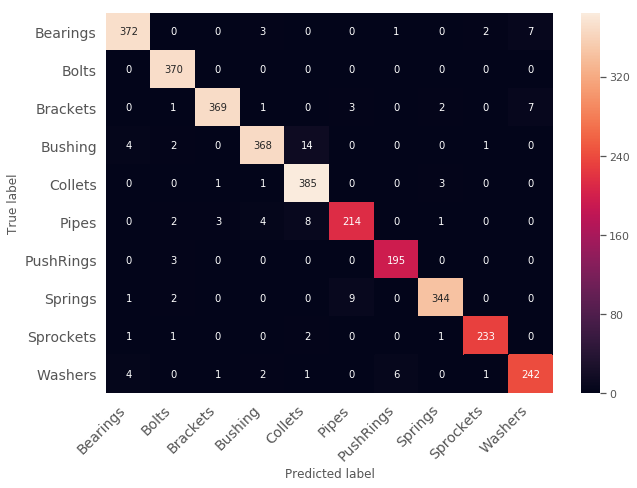

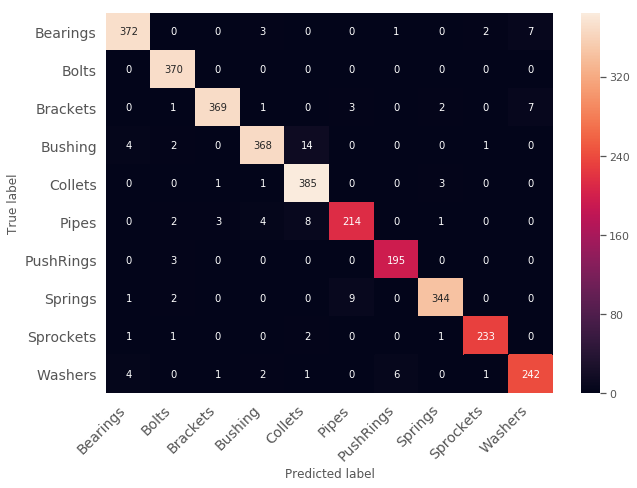

In [22]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
names = [val for val in label_to_name_dict.values()]
print_confusion_matrix(cm, class_names=names)